In [ ]:

import os
import cooler
import cooltools
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import subprocess
import bioframe
import numpy as np
from functools import partial
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 70
mpl.rcParams['font.size'] = 15
import logging
logging.getLogger('fontTools.subset').setLevel(logging.WARNING)
from concurrent import futures
import warnings
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.WARNING)

resolution = 1_000_000
genome_fa='/home/goubo/reference/index/bowtie2/mm10/raw/mm10.fa'
kept_samples= ['E11.5L1', 'E11.5L2', 'E12.5L5', 'E13.5C1', 'E13.5C4', 'E13.5C6', 'E14.5F5', 'E14.5F6']

proj_dir='/home/goubo/CRICK/CRICK/spaceA'
work_dir=os.path.join(proj_dir,'higashi_v2/higashi')
out_dir='/home/goubo/CRICK/CRICK/spaceA/fig'
os.chdir(out_dir)

filter_chrs=False

chroms=['chr1','chr2','chr4','chr5','chr8','chr10','chr11','chr15','chr16','chr17','chr19']


In [87]:
subprocess.run(f'if [ ! -f gap.txt.gz ]; then wget https://hgdownload.soe.ucsc.edu/goldenPath/mm10/database/gap.txt.gz --quiet;fi', shell=True)
mm10_gap=pd.read_table('gap.txt.gz',names=['bin','chrom','start','end','ix','n','size','type','bridge']) 

# Use bioframe to fetch the genomic features from the UCSC.
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
exclude_chroms=['chrX','chrY','chrM']
mm10_chromsizes=mm10_chromsizes.drop(exclude_chroms)
mm10_chromsizes = (pd.DataFrame(mm10_chromsizes).reset_index().rename(columns={"name": 'chrom'}))
mm10_cens=mm10_gap[mm10_gap['type']=='centromere'][['chrom','start','end']]
mm10_cens['mid']=mm10_cens.apply(lambda x: (int(x['start'])+int(x['end']))//2,axis='columns')
mm10_cens=mm10_cens.query("chrom not in @exclude_chroms")
# create a view with chromosome arms using chromosome sizes and definition of centromeres
mm10_arms = bioframe.make_chromarms(mm10_chromsizes,mm10_cens)
# select only those chromosomes available in cooler
mm10_arms = mm10_arms.query("chrom not in @exclude_chroms").reset_index(drop=True)

if filter_chrs:
    mm10_arms=mm10_arms[mm10_arms.chrom.isin(chroms)]
    f_append='_filter_chrs'
else:
    f_append=''
# mm10_arms.head()

In [88]:
def _cal_cvd_merged_of_cool(coolfile:str,resolution:int,cpus:int,view_df:pd.DataFrame) -> pd.DataFrame:
    subprocess.run(f'cooler balance {coolfile} --nproc {cpus}', shell=True)
    clr = cooler.Cooler(coolfile)
    cvd_smooth_agg = cooltools.expected_cis(clr=clr,view_df=view_df,smooth=True,
                                            aggregate_smoothed=True,nproc=cpus)
    cvd_smooth_agg['s_bp'] = cvd_smooth_agg['dist']* resolution
    cvd_smooth_agg['balanced.avg.smoothed.agg'].loc[cvd_smooth_agg['dist'] < 2] = np.nan
    # Just take a single value for each genomic separation
    cvd_merged = cvd_smooth_agg.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
    return cvd_merged

In [89]:
sample_cool_dict = {
    'fh_leiden_anno_man_Liver': 'fasthigashi_leiden_anno_man_Liver.cool',
    'fh_leiden_anno_man_Brain': 'fasthigashi_leiden_anno_man_Brain.cool',
    'fh_leiden_combined': 'fasthigashi_leiden_combined_.cool'

}

In [90]:
def cal_cvd_merged_of_sample(sample_id:str,work_dir:str,view_df:pd.DataFrame):
    cool_dir= os.path.join(work_dir,sample_id)
    os.chdir(cool_dir)
    cvd_merged_res={}

    for key, cool_append in sample_cool_dict.items():
        cvd_merged_result = _cal_cvd_merged_of_cool(
            coolfile=sample_id+'_'+cool_append,
            resolution=resolution,
            cpus=10,
            view_df=view_df
        )
        cvd_merged_res[key] = cvd_merged_result
        
    return cvd_merged_res
    

In [91]:
import matplotlib.ticker as ticker

def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

In [92]:

cpus=20
with futures.ProcessPoolExecutor(max_workers=cpus) as pool:
    res_samples= list(pool.map(partial(cal_cvd_merged_of_sample, work_dir=work_dir,view_df=mm10_arms),kept_samples))



INFO:root:creating a Pool of 10 workers
INFO:root:creating a Pool of 10 workers
INFO:root:creating a Pool of 10 workers
INFO:root:creating a Pool of 10 workers
INFO:root:creating a Pool of 10 workers
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
INFO:root:creating a Pool of 10 workers
INFO:root:creating a Pool of 10 workers
INFO:root:creating a Pool of 10 workers
INFO:root:creating a Pool of 10 workers
INFO:root:creating a Pool of 10 workers
INFO:root:creating a Pool of 10 workers
INFO:root:creating a Pool of 10 workers


In [93]:
res_samples_new=pd.DataFrame()

for group in sample_cool_dict.keys():
    for i,sample in enumerate(kept_samples):
            res_tmp=res_samples[i][group]
            res_tmp['group']=group
            res_tmp['stage']=sample[:-2]
            res_tmp['sample']=sample

            res_samples_new=pd.concat([res_samples_new,res_tmp],axis=0)



In [94]:
color_map=dict(zip(kept_samples, sns.color_palette("CMRmap", n_colors=len(kept_samples))))

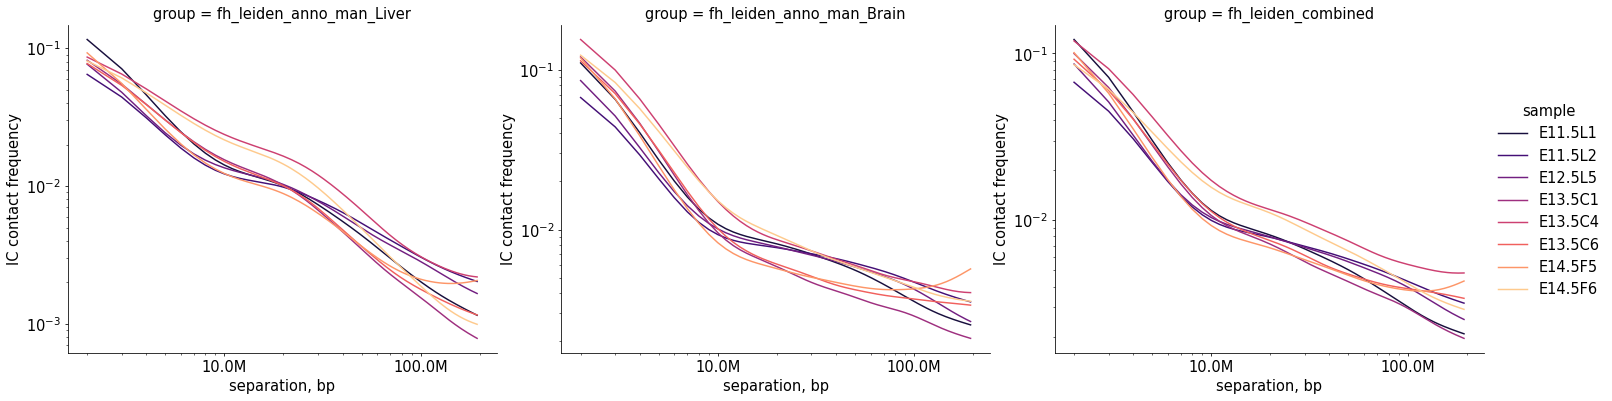

In [109]:
g2 = sns.FacetGrid(res_samples_new, col="group",hue='sample',aspect=1.2,
height=6,sharex=False,sharey=False, col_wrap=3
,palette='magma'
)

g2.map(sns.lineplot,'s_bp','balanced.avg.smoothed.agg')
g2.add_legend()
for ax in g2.axes.flat:
    ax.set_xscale('log', base=10)
    ax.set_yscale('log', base=10)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
    ax.set(xlabel='separation, bp',  ylabel='IC contact frequency')
g2.savefig(f'Lineplot_ContactDistance{f_append}_sample.pdf')

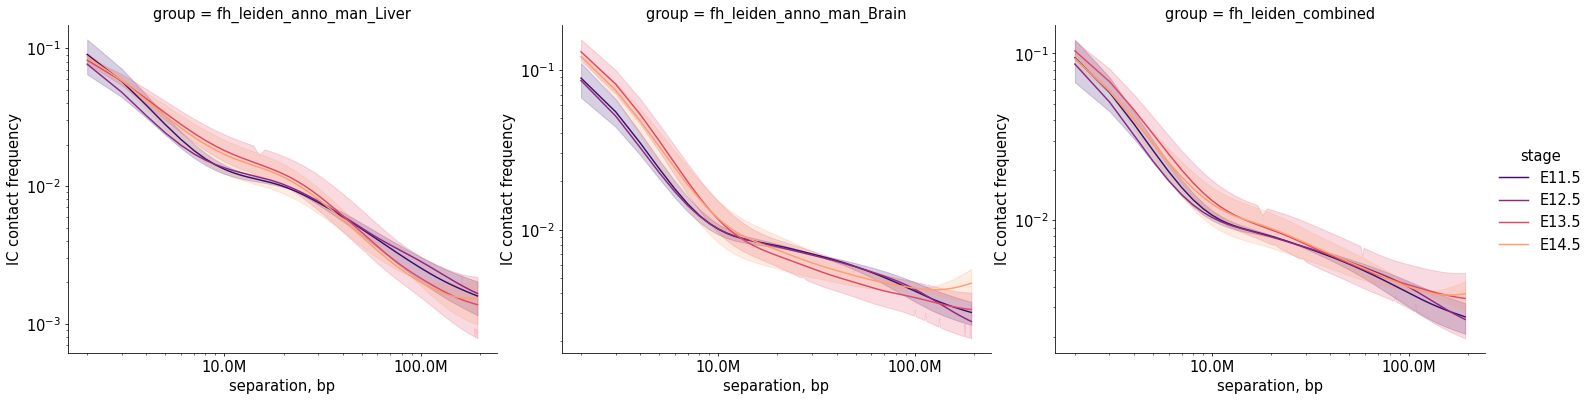

In [110]:
g2 = sns.FacetGrid(res_samples_new.reset_index(), col="group",hue='stage',aspect=1.2,
height=6,sharex=False,sharey=False, col_wrap=3,palette='magma',
)
g2.map(sns.lineplot,'s_bp','balanced.avg.smoothed.agg',markers=True,)
g2.add_legend()
for ax in g2.axes.flat:
    ax.set_xscale('log', base=10)
    ax.set_yscale('log', base=10)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
    ax.set(xlabel='separation, bp',  ylabel='IC contact frequency')

g2.savefig(f'Lineplot_ContactDistance{f_append}_stage.pdf')
g2.savefig(f'Lineplot_ContactDistance{f_append}_stage.png')
